## Shot hits minimum altitude before end of range

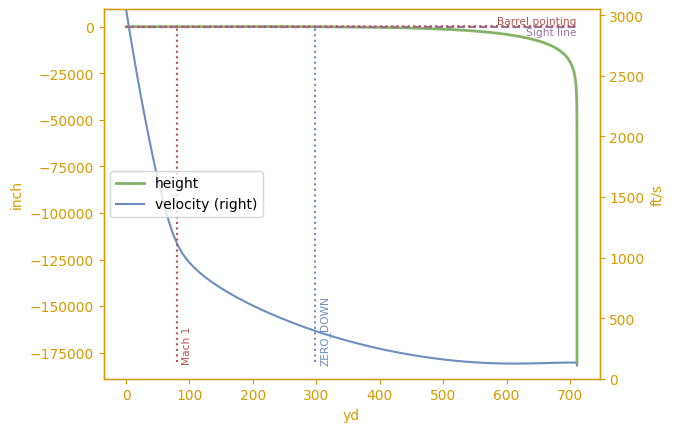

In [6]:
from typing_extensions import Union
from py_ballisticcalc import (DragModel, TableG1, Distance, Weight, Ammo, Velocity, Weapon, Shot,
                              Angular, Calculator, RangeError, HitResult, logger)

drag_model = DragModel(bc=0.03,
                       drag_table=TableG1,
                       diameter=Distance.Millimeter(23),
                       weight=Weight.Gram(188.5),
                       length=Distance.Millimeter(108.2))
ammo = Ammo(drag_model, Velocity.MPS(930))
weapon = Weapon()

zero = Shot(weapon=weapon,
            ammo=ammo,
            relative_angle=Angular.Degree(1.0))

calc = Calculator(_config={
    "cMinimumVelocity": 0,
    "cMinimumAltitude": -15000,  # Allow simulation to run trajectory to altitude of -15,000ft
})

# wrapper function to resolve RangeError and get HitResult
def must_fire(interface: Calculator, zero_shot, trajectory_range, extra_data, time_step,
              **kwargs) -> (HitResult, Union[RangeError, None]):
    """wrapper function to resolve RangeError and get HitResult"""
    try:
        # try to get valid result
        return interface.fire(zero_shot, trajectory_range, **kwargs, extra_data=extra_data, time_step=time_step), None
    except RangeError as err:
        # directly init hit result with incomplete data before exception occurred
        return HitResult(zero_shot, err.incomplete_trajectory, extra=extra_data), err

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)

if err:
    logger.warning("%s, trajectory incomplete", err)

# display hit result
from py_ballisticcalc.visualize.plot import show_hit_result_plot

#matplotlib.use('TkAgg')
p = hit_result.plot()
show_hit_result_plot()

In [8]:
df = hit_result.dataframe()
df.to_clipboard()
df.tail()

,time,distance,velocity,mach,height,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor,drag,energy,ogw,flag
11683,126.803037,710.98546,109.674049,0.093544,-179434.641480,-179434.641480,-1455.676495,0.0,0.0,710.98546,-90.0,0.550142,0.295031,77.687837,16.745195,8
11684,126.903343,710.98546,109.655662,0.093525,-179566.640977,-179566.640977,-1455.781175,0.0,0.0,710.98546,-90.0,0.550642,0.295080,77.661790,16.736774,8
11685,127.003665,710.98546,109.637278,0.093506,-179698.640474,-179698.640474,-1455.885704,0.0,0.0,710.98546,-90.0,0.551142,0.295129,77.635751,16.728357,8
11686,127.104004,710.98546,109.618897,0.093487,-179830.639971,-179830.639971,-1455.990082,0.0,0.0,710.98546,-90.0,0.551643,0.295178,77.609722,16.719945,8
11687,127.204360,710.98546,109.600519,0.093468,-179962.639468,-179962.639468,-1456.094311,0.0,0.0,710.98546,-90.0,0.552143,0.295227,77.583702,16.711537,8


## Dropped Projectile

In [10]:
ammo = Ammo(drag_model, Velocity.MPS(0))

zero = Shot(weapon=weapon,
            ammo=ammo)

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)

if err:
    logger.warning("%s, trajectory incomplete", err)

df = hit_result.dataframe()
df.to_clipboard()
df.tail()

,time,distance,velocity,mach,height,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor,drag,energy,ogw,flag
1233,124.775804,0.0,109.686111,0.093556,-179348.064902,-179348.064902,0.0,0.0,0.0,0.0,-90.0,0.549815,0.294999,77.704926,16.750720,8
1234,124.876098,0.0,109.667721,0.093537,-179480.064399,-179480.064399,0.0,0.0,0.0,0.0,-90.0,0.550314,0.295048,77.678873,16.742297,8
1235,124.976409,0.0,109.649335,0.093518,-179612.063896,-179612.063896,0.0,0.0,0.0,0.0,-90.0,0.550814,0.295097,77.652828,16.733877,8
1236,125.076737,0.0,109.630952,0.093499,-179744.063393,-179744.063393,0.0,0.0,0.0,0.0,-90.0,0.551315,0.295146,77.626793,16.725462,8
1237,125.177082,0.0,109.612573,0.093480,-179876.062890,-179876.062890,0.0,0.0,0.0,0.0,-90.0,0.551815,0.295195,77.600767,16.717052,8


## Near Vertical Trajectory

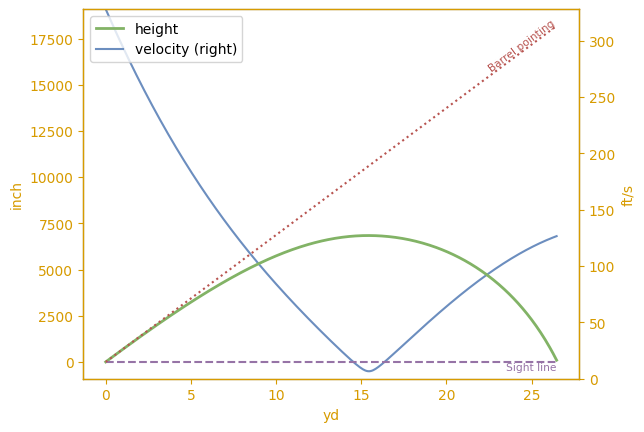

In [14]:
ammo = Ammo(drag_model, Velocity.MPS(100))

zero = Shot(weapon=weapon,
            ammo=ammo,
            relative_angle=Angular.Degree(87.0))

calc = Calculator(_config={
    "cMinimumVelocity": 0,
    "cMinimumAltitude": 0,
})

hit_result, err = must_fire(calc, zero, Distance.Meter(1000), extra_data=True, time_step=0.1)

if err:
    logger.warning("%s, trajectory incomplete", err)

p = hit_result.plot()
show_hit_result_plot()

In [15]:
df = hit_result.dataframe()
df.to_clipboard()
df.tail()

,time,distance,velocity,mach,height,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor,drag,energy,ogw,flag
393,11.642690,26.201490,125.021940,0.112000,558.811743,558.811743,544.778167,0.0,0.0,26.201490,-88.773999,-0.001364,0.214318,100.952654,24.804888,8
394,11.716564,26.266828,125.412530,0.112346,447.827307,447.827307,450.518420,0.0,0.0,26.266828,-88.797054,-0.001093,0.215002,101.584427,25.038099,8
395,11.794187,26.334371,125.809225,0.112687,330.843101,330.843101,342.005427,0.0,0.0,26.334371,-88.820739,0.000045,0.215887,102.228089,25.276447,8
396,11.871571,26.400589,126.190479,0.113028,213.858310,213.858310,225.442848,0.0,0.0,26.400589,-88.843815,0.000045,0.216498,102.848616,25.506938,8
397,11.950700,26.467163,126.567790,0.113366,93.873288,93.873288,100.030616,0.0,0.0,26.467163,-88.866877,0.000045,0.217102,103.464572,25.736421,8
